# Comparative analysis of divergent association scores in humans and GPT-3.5turbo and GPT-4
Concatenate all available results and compute contrasts of interest. 

## dependencies

In [12]:
import dat
import pandas as pd
import numpy as np

In [ ]:
# GloVe model from https://nlp.stanford.edu/projects/glove/
model = dat.Model("../glove.840B.300d.txt", "words.txt")

## Load human data
* Olson and coll. (2021) data - ~8k
* DAT website data harvest - 750k

In [5]:
#load DAT Olson's data
filename = "study2.tsv"

# read the data into a DataFrame
df = pd.read_csv(filename, sep='\t')

# extract the "dat" column as a list of floats
dat_study = df['dat'].astype(float).tolist()

In [4]:
#load DAT big data file
global_crea = pd.read_csv('./global-creativity.csv')
dat_study = global_crea['score']

## Fetch machine data
* GPT-3.5turbo
* GPT-4

1. Glob all data files (`.json`).
2. Iterate through samples.
3. Split the tokens and keep only the words.
4. Define strategy used from filename.
5. Define temperature level from filename.
6. Define model from filename
7. Compute DAT score for the given sample of 10 words. (DAT model computes pairwise semantic distances)
8. Store result as a row in a dataframe

In [23]:

import json
import pandas as pd
import fnmatch
import glob

# Define the file path where the data is located
data_path = '../data/*.json'

# Define a dictionary to store the results of model.dat(words)
results_dict = {'Temperature': [], 'Strategy': [], 'Score': [], 'Model': [], 'Control': []}

# Define a list of patterns to match file names with
file_patterns = ['*sample_*', '*gpt4_*']

# Loop through each file in the data path
for file in sorted(glob.glob(data_path)):
    
    # Check if the file matches any of the specified patterns
    if any(fnmatch.fnmatch(file, pattern) for pattern in file_patterns):
        
        # Open the file and load the JSON data
        with open(file, 'r') as f:
            data = json.load(f)
        
        # Loop through each key in the JSON data
        for i in data.keys():
            
            # Split the words into a list
            words = data[i].split()
            
            # Check if the length of the list is 20
            if len(words) == 20:
                # Select every other word starting from the first one
                w_idx = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
                words = [words[index] for index in w_idx]
            
            # Define the strategy based on the file name
            if 'sample_thes' in file or 'gpt4_thes' in file:
                strategy = 'Thesaurus'
            elif 'sample_oppo' in file or 'gpt4_oppo' in file:
                strategy = 'Opposition'
            elif 'sample_ety' in file or 'gpt4_ety' in file:
                strategy = 'Etymology'
            elif 'sample_rand' in file:
                strategy = 'Random'
            elif 'sample_none' in file or 'gpt4_none' in file:
                strategy = 'Original instructions'
            elif 'sample_nothing' in file or 'gpt4_nothing' in file:
                strategy = 'Control'
            
            # Define the condition based on the file name
            if 'temp1.5' in file:
                condition = 'High'
            elif 'temp0.5' in file:
                condition = 'Low'
            else:
                condition = 'None'
            
            # Define the model based on the file name
            if 'gpt4' in file:
                llm = 'GPT4'
            else:
                llm = 'GPT3'
            
            # Loop through each word in the list
            score = model.dat(words)
             
            # Append the results to the dictionary
            results_dict['Temperature'].append(condition)
            results_dict['Strategy'].append(strategy)
            results_dict['Score'].append(score)
            results_dict['Model'].append(llm)
            if strategy == 'Control':
                results_dict['Control'].append('Control')
            else:
                results_dict['Control'].append('Original instructions')

# Convert the results dictionary to a Pandas DataFrame
results_df = pd.DataFrame(results_dict)

Number of valid words 10
Number of valid words 9
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 10
Number of valid words 16
Number of valid words 18
Number of valid words 19
Number of valid words 17
Number of valid words 20
N

## Concatenate all human and machine data 

In [24]:
results_df = pd.concat([results_df, pd.DataFrame({'Temperature': np.tile(None, len(DAT_bigdata)),
                                                  'Strategy': np.tile(None, len(DAT_bigdata)),
                                                  'Score': np.array(DAT_bigdata),
                                                  'Model': np.tile('Human (750k)', len(DAT_bigdata)),
                                                  'Control': np.tile(None, len(DAT_bigdata))})])
results_df = pd.concat([results_df, pd.DataFrame({'Temperature': np.tile(None, len(dat_study)),
                                                  'Strategy': np.tile(None, len(dat_study)),
                                                  'Score': np.array(dat_study),
                                                  'Model': np.tile('Human (8k)', len(dat_study)),
                                                  'Control': np.tile(None, len(dat_study))})])


In [25]:
results_df.to_csv('concatenated_results.csv', index=False)

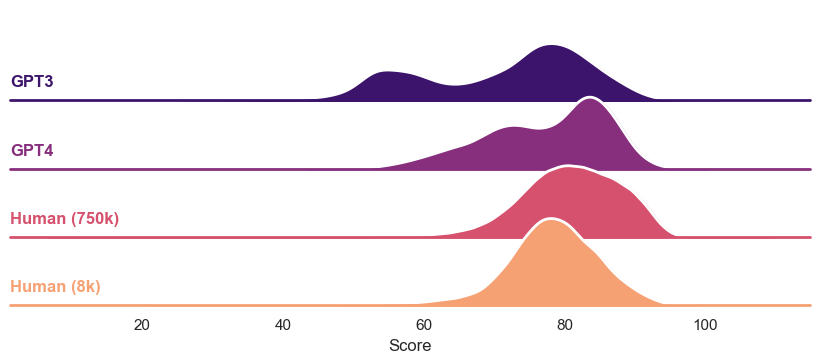

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.color_palette('magma',n_colors=4, desat=.9)
g = sns.FacetGrid(results_df, row="Model", hue="Model", aspect=9, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Score")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

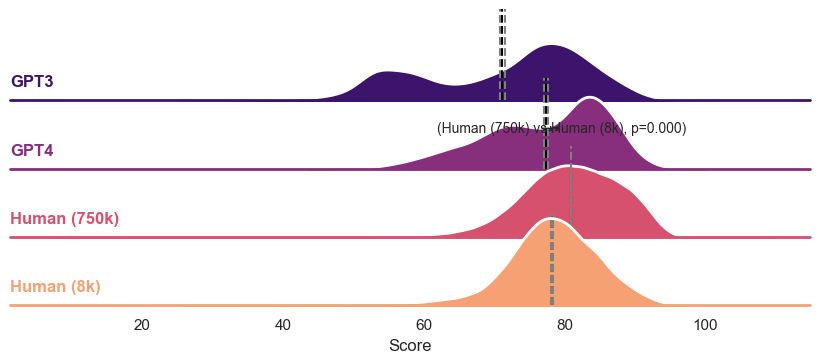

In [47]:
# Initialize the FacetGrid object
pal = sns.color_palette('magma',n_colors=4, desat=.9)
g = sns.FacetGrid(results_df, row="Model", hue="Model", aspect=9, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "Score")

# Calculate mean and confidence interval for each model's distribution
mean_conf = results_df.groupby('Model')['Score'].agg(['mean', 'sem'])
mean_conf['ci_low'] = mean_conf['mean'] - 1.96 * mean_conf['sem']
mean_conf['ci_high'] = mean_conf['mean'] + 1.96 * mean_conf['sem']
mean_conf.reset_index(inplace=True)

# Add vertical lines for mean and confidence intervals
for ax, model in zip(g.axes.flat, mean_conf['Model']):
    ax.axvline(mean_conf[mean_conf['Model'] == model]['mean'].values[0], color='black', linestyle='--')
    ax.axvline(mean_conf[mean_conf['Model'] == model]['ci_low'].values[0], color='gray', linestyle='--')
    ax.axvline(mean_conf[mean_conf['Model'] == model]['ci_high'].values[0], color='gray', linestyle='--')

# Contrast all models using nonparametric t-tests
pvals = pd.DataFrame(index=mean_conf['Model'], columns=mean_conf['Model'], dtype=float)
for i, model1 in enumerate(mean_conf['Model']):
    for j, model2 in enumerate(mean_conf['Model']):
        if i >= j:
            continue
        res = stats.mannwhitneyu(results_df[results_df['Model'] == model1]['Score'], 
                                 results_df[results_df['Model'] == model2]['Score'], 
                                 alternative='greater')
        pvals.loc[model1, model2] = res.pvalue
        pvals.loc[model2, model1] = res.pvalue

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Add p-values for each pair of models
for i, model1 in enumerate(mean_conf['Model']):
    for j, model2 in enumerate(mean_conf['Model']):
        if i >= j:
            continue
        pval = pvals.loc[model1, model2]
        if np.isnan(pval):
            continue
        star = ''
        if pval < 0.001:
            star = '***'
        elif pval < 0.01:
            star = '**'
        elif pval < 0.05:
            star = '*'
        if star:
            x = mean_conf[mean_conf['Model'].isin([model1, model2])]['mean'].mean()
            y = 1.1*g.axes.flat[i].get_ylim()[1]
            g.axes.flat[i].text(x, y, star, fontsize=12, fontweight='bold', ha='right')
            g.axes.flat[i].text(x, y+0.05*g.axes.flat[i].get_ylim()[1], f"({model1} vs {model2}, p={pval:.3f})", fontsize=10, ha='center') 


In [45]:
pvals

Model,GPT3,GPT4,Human (750k),Human (8k)
Model,,,,
GPT3,NaN,NaN,NaN,NaN
GPT4,NaN,NaN,NaN,NaN
Human (750k),NaN,NaN,NaN,1.956117e-304
Human (8k),NaN,NaN,1.956117e-304,NaN


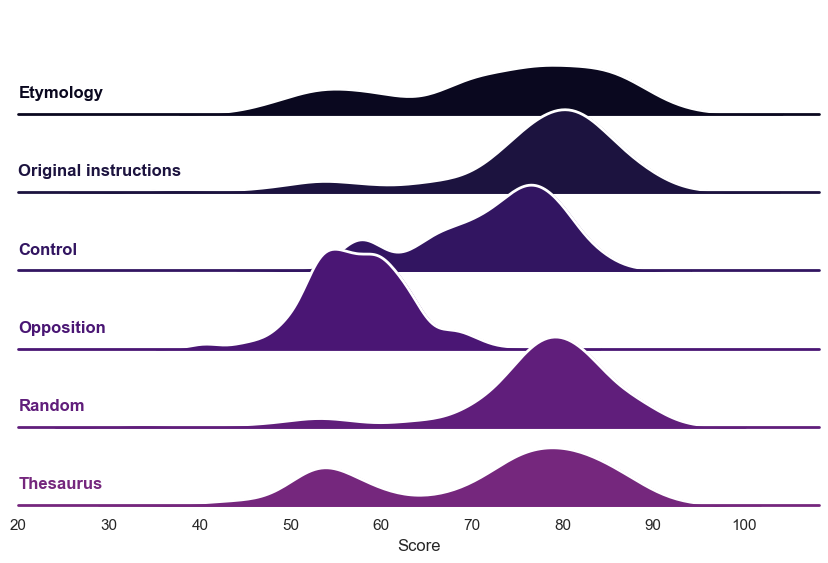

In [28]:
# Initialize the FacetGrid object
pal = sns.color_palette('magma',n_colors=16, desat=.9)
g = sns.FacetGrid(results_df.loc[results_df['Model']=='GPT3'], row="Strategy", hue="Strategy", aspect=9, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Score")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [ ]:
# Initialize the FacetGrid object
pal = sns.color_palette('CMRmap',n_colors=4, desat=.9)
g = sns.FacetGrid(results_df.loc[results_df['Model']=='GPT4'], row="Strategy", hue="Strategy", aspect=9, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Score")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
print('GPT4 - Strategies')

In [ ]:
list_of_dfs = [results_df.loc[(results_df['Model']=='GPT4') & (results_df['Control']=='Control')],
               results_df.loc[(results_df['Model']=='GPT4') & (results_df['Control']=='Original instructions')]]
for df in list_of_dfs:
      # Initialize the FacetGrid object
      pal = sns.color_palette('CMRmap',n_colors=4, desat=.9)
      g = sns.FacetGrid(df, row="Temperature", hue="Temperature", aspect=9, height=1, palette=pal)

      # Draw the densities in a few steps
      g.map(sns.violinplot, "Score"),
            #bw_adjust=1, clip_on=False,
            #fill=True, alpha=1, linewidth=1.5)
      #g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=1)

      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                        ha="left", va="center", transform=ax.transAxes)


      g.map(label, "Score")

      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.25)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      g.set(yticks=[], ylabel="")
      g.despine(bottom=True, left=True)

In [ ]:
results_df.loc[(results_df['Model']=='GPT4') & (results_df['Control']=='Original instructions')]